In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import mp
import BaseMPClassifier as BaseMP
import DistanceDistributionProfile as DDP
import DistanceDistributionProfile_w as DDPw
from scipy.signal import find_peaks

from sklearn import svm
from sklearn.metrics import classification_report

import warnings
#warnings.filterwarnings("ignore")

D:\Miniconda\envs\sktime\lib\site-packages\mass_ts\_mass_ts.py:18: UserWarning: GPU support will not work. You must pip install mass-ts[gpu].
  'GPU support will not work. You must pip install mass-ts[gpu].')


In [8]:
# loading dataset
import os
folder = 'ucr_archive/'
file = 'ItalyPowerDemand'
train = pd.read_csv(os.path.join(folder+file,file+'_TRAIN.tsv'),sep="\t",header=None,on_bad_lines='skip')
test = pd.read_csv(os.path.join(folder+file,file+'_TEST.tsv'),sep="\t",header=None,on_bad_lines='skip')

train_y = train.pop(0)
test_y = test.pop(0)
train_X = train.to_numpy()
test_X = test.to_numpy()

print([len(train_X), len(train_y), len(test_X), len(test_y),len(np.unique(train_y)), len(np.unique(test_y))])

[20, 20, 343, 343, 2, 2]


## 1. Baseline MP shapelet candidates screening

In [14]:
%%time
sorted_candidates, sorted_cand_idx = BaseMP.sort_by_quality(train_X, train_y,  n_candidates=50, max_length=0.5, overlap= False)

In [46]:
%%time
### weighted voting classifier ### 
from sklearn.metrics import classification_report
from sklearn.base import clone
import shapelet_classifier

filename1 = os.path.join('results','ddp',file+'_sorted_candidates.sav')
(sorted_candidates,sorted_cand_idx,runtime) = pickle.load(open(filename1, 'rb'))

classes = np.unique(train_y)
result = pd.DataFrame(columns=['dataset','runtime','k','classifier','train_acc','test_acc'])
result1 = pd.DataFrame(columns=['dataset','runtime','k','classifier','train_acc','test_acc'])

# find maximum number of shapelets available
min_n_candidates = min([len(sorted_candidates[ele]) for ele in sorted_candidates])
n_shapelets = min(min_n_candidates,30)
# transformation
best_shapelets, best_s_idx = DDP.best_shapelets(classes, sorted_candidates, sorted_cand_idx, n_shapelets)
transformed_train_X = DDP.transform(train_X, best_shapelets)
transformed_test_X = DDP.transform(test_X, best_shapelets)

# classification
shapelet_scores=[]
for k in range(n_shapelets):
    indices = np.array([range(i*n_shapelets,i*n_shapelets+k+1) for i in range(len(classes))]).reshape(-1)
    train_X_hat = transformed_train_X[indices].transpose()
    test_X_hat = transformed_test_X[indices].transpose()
    score,classifier,clf = shapelet_classifier.classifier(train_X_hat,train_y)
    model = clf.fit(train_X_hat,train_y)
    shapelet_scores.append(score)
    
# method 1
    try:
        train_result = classification_report(train_y,model.predict(train_X_hat), output_dict=True)
        test_result = classification_report(test_y,model.predict(test_X_hat), output_dict=True)
        result.loc[len(result)] = [file, runtime, k+1, classifier, train_result['accuracy'], test_result['accuracy']]
    except:
        result.loc[len(result)] = [file, runtime, k+1, classifier, 'error', 'error']
        pass

print(shapelet_scores)
# method 2
rank = shapelet_classifier.get_srank(shapelet_scores)
print(rank)
indices = np.array([rank+i*n_shapelets for i in range(len(classes))]).reshape(-1)
print(indices)
train_X_hat = transformed_train_X[indices].transpose()
test_X_hat = transformed_test_X[indices].transpose()
_,classifier,clf = shapelet_classifier.classifier(train_X_hat,train_y)
model = clf.fit(train_X_hat,train_y)
try:
    train_result = classification_report(train_y,model.predict(train_X_hat), output_dict=True)
    test_result = classification_report(test_y,model.predict(test_X_hat), output_dict=True)
    result1.loc[len(result1)] = [file, runtime, len(rank), classifier, train_result['accuracy'], test_result['accuracy']]
except:
    result1.loc[len(result1)] = [file, runtime, len(rank), classifier, 'error', 'error']
    pass
    
print(result)
print(result1)

C:\Users\Administrator\Dropbox\Academic\UOA PhD\Thesis\Data\shapelets\mp.py:70: RuntimeWarning: divide by zero encountered in true_divide
  (sigmax[m - 1:n] * sigmay))
C:\Users\Administrator\Dropbox\Academic\UOA PhD\Thesis\Data\shapelets\mp.py:70: RuntimeWarning: invalid value encountered in multiply
  (sigmax[m - 1:n] * sigmay))
C:\Users\Administrator\Dropbox\Academic\UOA PhD\Thesis\Data\shapelets\mp.py:70: RuntimeWarning: invalid value encountered in true_divide
  (sigmax[m - 1:n] * sigmay))


[0.9457142857142857, 0.9860714285714286, 0.9860714285714286, 0.9860714285714286, 0.9860714285714286, 0.9860714285714286, 0.9860714285714286, 0.9860714285714286, 0.9860714285714286, 0.9860714285714286, 0.9860714285714286, 0.9860714285714286, 0.9860714285714286, 0.9860714285714286, 0.9860714285714286, 0.9721428571428571, 0.9721428571428571, 0.9860714285714286, 0.9860714285714286, 0.9860714285714286, 0.9860714285714286, 0.9860714285714286, 0.9860714285714286, 0.9860714285714286, 0.9860714285714286, 0.9860714285714286, 0.9860714285714286, 0.9860714285714286, 0.9860714285714286, 0.9721428571428571]
[0 1]
[ 0  1 30 31]
                  dataset    runtime   k classifier  train_acc  test_acc
0   SonyAIBORobotSurface1  12.528438   1      SVM_Q        1.0  0.818636
1   SonyAIBORobotSurface1  12.528438   2      SVM_L        1.0  0.803661
2   SonyAIBORobotSurface1  12.528438   3      SVM_L        1.0  0.811980
3   SonyAIBORobotSurface1  12.528438   4      SVM_L        1.0  0.810316
4   SonyAIBORo

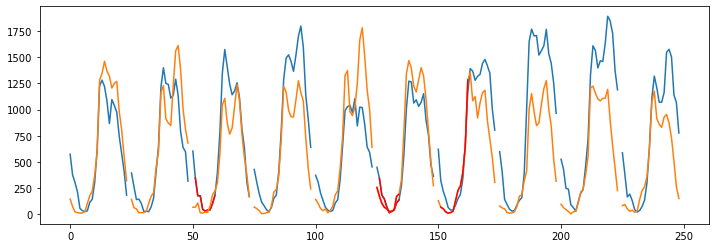

In [11]:
plt.rcParams['figure.figsize'] = [12, 4]
for i in range(len(classes)):
    label=classes[i]
    T = np.concatenate([np.append(Ti, np.nan) for Ti in train_X[train_y==label]], axis=None)
    plt.plot(T)
    idx = best_s_idx[label]
    for j in range(len(idx)):        
        plt.plot(np.arange(idx[j][1],idx[j][1]+idx[j][0],1),
                 best_shapelets[i*2+j],
                 color = 'red'
                )
        

## 2. distance distribution profile



In [5]:
%%time
sorted_candidates, sorted_cand_idx = DDP.DDP_candidates(train_X, train_y, n_candidates=50, max_length=0.5, overlap='loose')

yes
loose
loose
CPU times: total: 250 ms
Wall time: 3.77 s


In [6]:
%%time
classes = np.unique(train_y)
best_shapelets, best_s_idx = DDP.best_shapelets(classes, sorted_candidates, sorted_cand_idx, k=2)

transformed_train_X = DDP.transform(train_X, best_shapelets)
transformed_test_X = DDP.transform(test_X, best_shapelets)

#from sklearn import svm
#from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import AdaBoostClassifier

#clf = svm.SVC()
clf = KNN(n_neighbors=1)
#clf = AdaBoostClassifier(n_estimators=100)
model = clf.fit(transformed_train_X,train_y)

train_result = classification_report(train_y,model.predict(transformed_train_X), output_dict=False)
test_result = classification_report(test_y,model.predict(transformed_test_X), output_dict=False)
print(train_result)
print(test_result)


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        34
           2       1.00      1.00      1.00        33

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67

              precision    recall  f1-score   support

           1       0.92      0.93      0.93       513
           2       0.93      0.92      0.92       516

    accuracy                           0.93      1029
   macro avg       0.93      0.93      0.93      1029
weighted avg       0.93      0.93      0.93      1029

CPU times: total: 2.06 s
Wall time: 2.07 s


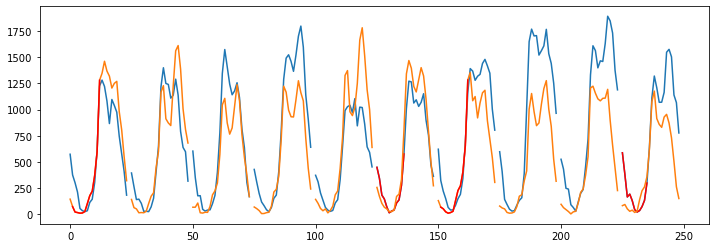

In [15]:
plt.rcParams['figure.figsize'] = [12, 4]
for i in range(len(classes)):
    label=classes[i]
    T = np.concatenate([np.append(Ti, np.nan) for Ti in train_X[train_y==label]], axis=None)
    plt.plot(T)
    idx = best_s_idx[label]
    for j in range(len(idx)):        
        plt.plot(np.arange(idx[j][1],idx[j][1]+idx[j][0],1),
                 best_shapelets[i*2+j],
                 color = 'red'
                )
        

## 3. DDP with Mann Whitney U Test

In [7]:
%%time
sorted_candidates, sorted_cand_idx = DDPw.DDP_candidates(train_X, train_y, n_candidates=50, max_length=0.5, overlap='loose')

yes
loose
loose
CPU times: total: 250 ms
Wall time: 7.07 s


In [8]:
%%time
classes = np.unique(train_y)
best_shapelets, best_s_idx = DDPw.best_shapelets(classes, sorted_candidates, sorted_cand_idx, k=1)

transformed_train_X = DDPw.transform(train_X, best_shapelets)
transformed_test_X = DDPw.transform(test_X, best_shapelets)

#from sklearn import svm
#from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import AdaBoostClassifier

#clf = svm.SVC()
clf = KNN(n_neighbors=1)
#clf = AdaBoostClassifier(n_estimators=100)
model = clf.fit(transformed_train_X,train_y)

train_result = classification_report(train_y,model.predict(transformed_train_X), output_dict=False)
test_result = classification_report(test_y,model.predict(transformed_test_X), output_dict=False)
print(train_result)
print(test_result)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        34
           2       1.00      1.00      1.00        33

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67

              precision    recall  f1-score   support

           1       0.91      0.90      0.91       513
           2       0.90      0.91      0.91       516

    accuracy                           0.91      1029
   macro avg       0.91      0.91      0.91      1029
weighted avg       0.91      0.91      0.91      1029

CPU times: total: 1.05 s
Wall time: 1.05 s
